Cell Apoptosis Tutorial for the Paper [Systems biology informed deep learning for inferring parameters and hidden dynamics](https://journals.plos.org/ploscompbiol/article/file?id=10.1371/journal.pcbi.1007575&type=printable) by Yazdani et al.

[Original Code Source](https://github.com/alirezayazdani1/SBINNs)

1. Connect to a GPU enabled run-time
2. Run all cells for default configurations.

This supplements the presentation for APPM 5720: Data Driven Modeling.
Authors: Josh Myers-Dean, Leonardo Orozco, and Wenhao Wang

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [1]:
!git clone https://github.com/alirezayazdani1/SBINNs 

fatal: destination path 'SBINNs' already exists and is not an empty directory.


In [2]:
%cd SBINNs
%mkdir figures

/content/SBINNs
mkdir: cannot create directory ‘figures’: File exists


In [3]:
%pip install -r requirements.txt &> /dev/null
%pip install matplotlib &> /dev/null

In [4]:
import numpy as np
from scipy.integrate import odeint

import deepxde as dde
from deepxde.backend import tf

import numpy as np
import time

from matplotlib import pyplot as plt
from matplotlib import style
style.use('ggplot')

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


The code below came largely uncommented - we will only be playing with the layer/neuron configuration. The authors train for 1.5 million epochs which is unfeasable for a tutorial so we will only be training for a small amount of iteration (1000-10,000) and observing how changes in our neural network affect the output.

In [26]:

def apoptosis_model(
    t, x0, k1, kd1, kd2, k3, kd3, kd4, k5, kd5, kd6,
):
    '''Returns the DE for cell apoptosis given initial conditions'''
    def func(x, t):
        v4_1 = kd1 * x[4]
        v4_2 = kd2 * x[4]
        v5_3 = kd3 * x[5]
        v5_4 = kd4 * x[5]
        v7_5 = kd5 * x[7]
        v7_6 = kd6 * x[7]
        v03 = k1 * x[3] * x[0]
        v12 = k3 * x[1] * x[2]
        v36 = k5 * x[6] * x[3]

        return [
            -v03 + v4_1,
            v4_2 - v12 + v5_3 + v5_4,
            -v12 + v5_3,
            v5_4 - v03 + v4_1 - v36 + v7_5 + v4_2,
            -v4_2 + v03 - v4_1,
            -v5_4 + v12 - v5_3,
            -v36 + v7_5 + v7_6,
            v36 - v7_5 - v7_6,
        ]

    return odeint(func, x0, t)


def pinn(data_t, data_y):
    '''
    Defines the network and training stage for cell apoptosis model
    '''

    # DE parameters
    k1 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32))
    kd1 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32)) * 10
    kd2 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32)) * 10
    k3 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32)) * 10
    kd3 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32)) * 100
    kd4 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32))
    k5 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32)) * 1e4
    kd5 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32)) * 0.01
    kd6 = tf.math.softplus(tf.Variable(1, trainable=True, dtype=tf.float32)) * 0.1

    var_list = [k1, kd1, kd2, k3, kd3, kd4, k5, kd5, kd6]

    def ODE(t, y):
        v4_1 = kd1 * y[:, 4:5]
        v4_2 = kd2 * y[:, 4:5]
        v5_3 = kd3 * y[:, 5:6]
        v5_4 = kd4 * y[:, 5:6]
        v7_5 = kd5 * y[:, 7:8]
        v7_6 = kd6 * y[:, 7:8]
        v03 = k1 * y[:, 3:4] * y[:, 0:1]
        v12 = k3 * y[:, 1:2] * y[:, 2:3]
        v36 = k5 * y[:, 6:7] * y[:, 3:4]

        return [
            tf.gradients(y[:, 0:1], t)[0] - (-v03 + v4_1),
            tf.gradients(y[:, 1:2], t)[0] - (v4_2 - v12 + v5_3 + v5_4),
            tf.gradients(y[:, 2:3], t)[0] - (-v12 + v5_3),
            tf.gradients(y[:, 3:4], t)[0] - (v5_4 - v03 + v4_1 - v36 + v7_5 + v4_2),
            tf.gradients(y[:, 4:5], t)[0] - (-v4_2 + v03 - v4_1),
            tf.gradients(y[:, 5:6], t)[0] - (-v5_4 + v12 - v5_3),
            tf.gradients(y[:, 6:7], t)[0] - (-v36 + v7_5 + v7_6),
            tf.gradients(y[:, 7:8], t)[0] - (v36 - v7_5 - v7_6),
        ]

    geom = dde.geometry.TimeDomain(data_t[0, 0], data_t[-1, 0])

    # Right point
    def boundary(x, _):
        return np.isclose(x[0], data_t[len(data_t) // 2, 0])

    y1 = data_y[len(data_t) // 2]
    bc0 = dde.DirichletBC(geom, lambda X: y1[0], boundary, component=0)
    bc1 = dde.DirichletBC(geom, lambda X: y1[1], boundary, component=1)
    bc2 = dde.DirichletBC(geom, lambda X: y1[2], boundary, component=2)
    bc3 = dde.DirichletBC(geom, lambda X: y1[3], boundary, component=3)
    bc4 = dde.DirichletBC(geom, lambda X: y1[4], boundary, component=4)
    bc5 = dde.DirichletBC(geom, lambda X: y1[5], boundary, component=5)
    bc6 = dde.DirichletBC(geom, lambda X: y1[6], boundary, component=6)
    bc7 = dde.DirichletBC(geom, lambda X: y1[7], boundary, component=7)

    # Observes
    n = len(data_t)
    idx = np.append(
        np.random.choice(np.arange(1, n - 1), size=n // 5, replace=False), [0, n - 1]
    )
    ptset = dde.bc.PointSet(data_t[idx])
    inside = lambda x, _: ptset.inside(x)
    observe_y3 = dde.DirichletBC(
        geom, ptset.values_to_func(data_y[idx, 3:4]), inside, component=3
    )
    np.savetxt("apoptosis_input.dat", np.hstack((data_t[idx], data_y[idx, 3:4])))

    data = dde.data.PDE(
        geom, ODE, [bc0, bc1, bc2, bc3, bc4, bc5, bc6, bc7, observe_y3], anchors=data_t,
    )

    # TUTORIAL ACTION ITEM
    # Change these to affect network architecture
    layer_width = [256]
    num_layers = 4

    layers = [1] + layer_width * num_layers + [8]
    net = dde.maps.FNN(layers, "swish", "Glorot normal")

    def feature_transform(t):
        t = 0.1 * t
        return tf.concat((t, tf.exp(-t)), axis=1,)

    net.apply_feature_transform(feature_transform)

    def output_transform(t, y):
        return (
            data_y[0]
            + tf.math.tanh(t) * tf.constant([1, 1, 1, 1, 0.01, 0.1, 0.01, 0.01]) * y
        )

    net.apply_output_transform(output_transform)

    model = dde.Model(data, net)

    checkpointer = dde.callbacks.ModelCheckpoint(
        "./model/model.ckpt", verbose=1, save_better_only=True, period=1000
    )
    variable = dde.callbacks.VariableValue(
        var_list, period=1000, filename="variables.dat", precision=3,
    )
    callbacks = [checkpointer, variable]

    model.compile(
        "adam",
        lr=1e-3,
        # loss_weights=[1, 1, 1, 1, 1e3, 1, 1, 1] + [1, 1, 1, 1, 100, 10, 100, 100, 1e2],  # noiseless
        loss_weights=[1, 1, 1, 1, 1e3, 1, 1, 1] + [1, 1, 1, 1, 100, 10, 100, 100, 10],  # death noise
        # loss_weights=[1, 1, 1, 1, 1e3, 1, 1, 1] + [1, 1, 1, 1, 100, 10, 100, 100, 1],  # survival noise
    )

    # TUTORIAL ACTION ITEM
    # Change number of epochs to see how it affects the output
    # 10,000 epochs takes roughly 8 minutes with the default architecture
    epochs = 5000

    losshistory, train_state = model.train(
        epochs=epochs,  # death noise
        display_every=1000,
        callbacks=callbacks,
    )
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)
    var_list = [model.sess.run(v) for v in var_list]
    return var_list, train_state, num_layers, layer_width, epochs


def main():
    t = np.arange(0, 60, 0.1)[:, None]
    t_scale = 3600
    c_scale = 1e5
    noise = 0.05

    # Data
    x0 = [1.34e5, 1e5, 2.67e5, 0, 0, 0, 2.9e3, 0]  # death
    # x0 = [1.34e5, 1e5, 2.67e5, 0, 0, 0, 2.9e4, 0]  # survival
    x0 = [x / c_scale for x in x0]
    var_list = [2.67e-9, 1e-2, 8e-3, 6.8e-8, 5e-2, 1e-3, 7e-5, 1.67e-5, 1.67e-4]
    var_list = [v * t_scale for v in var_list]
    for i in [0, 3, 6]:
        var_list[i] *= c_scale
    y = apoptosis_model(np.ravel(t), x0, *var_list)
    np.savetxt("apoptosis.dat", np.hstack((t, y)))
    # Add noise
    if noise > 0:
        std = noise * y.std(0)
        tmp = np.copy(y[len(t) // 2])
        y[1:, :] += np.random.normal(0, std, (y.shape[0] - 1, y.shape[1]))
        y[len(t) // 2] = tmp
        np.savetxt("apoptosis_noise.dat", np.hstack((t, y)))

    # Train
    var_list, train_state, num_layers, layer_width, epochs = pinn(t, y)

    # Prediction
    y = apoptosis_model(np.ravel(t), x0, *var_list)
    np.savetxt("apoptosis_pred.dat", np.hstack((t, y)))
    var_list = [v / t_scale for v in var_list]
    for i in [0, 3, 6]:
        var_list[i] /= c_scale
    return var_list, train_state, num_layers, layer_width, epochs

Compiling model...
Building feed-forward neural network...
'build' took 0.106215 s



/usr/local/lib/python3.7/dist-packages/deepxde/maps/fnn.py:82: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_regularizer=self.regularizer,
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 5.824076 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                    Test loss                                                                                                                                                                     Test metric
0         [2.25e-03, 1.08e+03, 1.08e+03, 1.05e+02, 2.38e+00, 1.08e+03, 1.04e+02, 1.04e+02, 1.76e+00, 1.89e+00, 6.83e+00, 4.39e+00, 4.54e-07, 3.36e-05, 8.47e-02, 8.63e-02, 3.94e+01]    [2.25e-03, 1.08e+03, 1.08e+03, 1.05e+02, 2.38e+00, 1.08e+03, 1.04e+02, 1.04e+02, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  
1000      [3.79e-02, 3.98e+00, 3.42e+00, 1.09e-03, 2.94e-04, 4.42e+00, 1.22e-03, 1.30e-03, 1.48e-02, 4.38e+00, 1.09e-01, 4.49e+00, 6.14e-08, 4.07e-04, 5.65e-02, 3.20e-04, 4.03e+01]    [3.79e-02, 

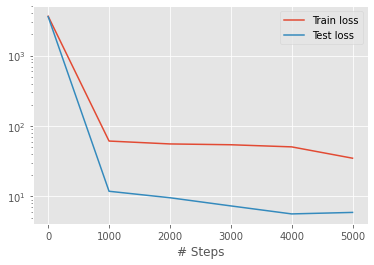

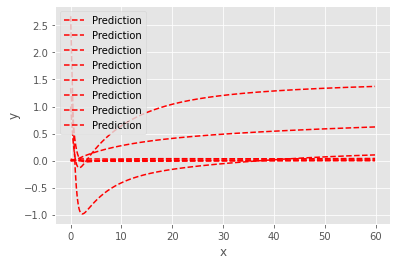

Training took  4.182 minutes


In [27]:
tic = time.time()
preds, train_state, layers, neurons, epochs = main()
toc = time.time()
print(f"Training took {(toc - tic) / 60: .3f} minutes")

In [28]:
'''
Regenerate data for comparison
'''

t = np.arange(0, 60, 0.1)[:, None]
t_scale = 3600
c_scale = 1e5
noise = 0.05

# Data
x0 = [1.34e5, 1e5, 2.67e5, 0, 0, 0, 2.9e3, 0]  # death
# x0 = [1.34e5, 1e5, 2.67e5, 0, 0, 0, 2.9e4, 0]  # survival
x0 = [x / c_scale for x in x0]
var_list = [2.67e-9, 1e-2, 8e-3, 6.8e-8, 5e-2, 1e-3, 7e-5, 1.67e-5, 1.67e-4]
var_list = [v * t_scale for v in var_list]
for i in [0, 3, 6]:
    var_list[i] *= c_scale
y = apoptosis_model(np.ravel(t), x0, *var_list)
preds = np.asarray(preds)


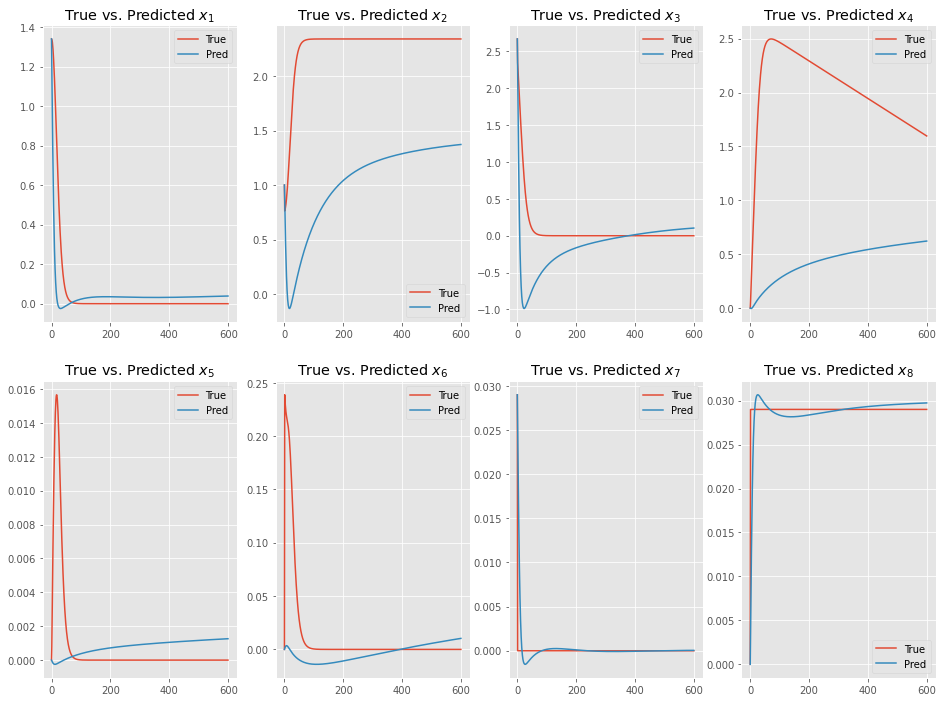

In [29]:
'''
generate plots for comparisons
'''

# change this to reflect your number of layers/neurons
fig, ax = plt.subplots(2,4, figsize=(16,12))
ax = ax.flatten()
for i in range(y.shape[1]):
  ax[i].plot(y[:, i], label='True')
  ax[i].plot(train_state.best_y[:, i], label='Pred')
  ax[i].set_title(f"True vs. Predicted $x_{i+1}$")
  ax[i].legend()
fig.savefig(f'figures/{layers}_{neurons[0]}_{epochs}.png')